### CNN for pixel-wise ship detection¶on Sentinel 1 image

In [1]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D, Dense, Dropout, Input, Flatten, Activation, Reshape
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.metrics import binary_accuracy
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow_adons as tfa

Using TensorFlow backend.


In [2]:
import os
import time

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rasterio as rio
import glob
import pylab
import cv2
%matplotlib inline

import sys
sys.path.append(r'C:\Users\arman\Documents\GitHub\sar_ship_detect\scripts')
from utils import data_split, lee_filter, im_resize, bbox_draw, data_extractor, model_history_plot
from cnn_utils import SAR_ObjectDetect_CNN

In [3]:
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
# Configs
RADAR_PATH = join(PATH, 'data/SAR_test/test1019')
OUT_PATH = RADAR_PATH

In [4]:
radar_natural = glob.glob(join(RADAR_PATH, '*dB*'))[0]
angle_im = glob.glob(join(RADAR_PATH, '*angle*'))[0]

src_natural = rio.open(radar_natural)
src_angle = rio.open(angle_im)
Window = (80, 80)

# get the dimencions for cropping the image
height, width = (src_natural.shape[0]//Window[0])*Window[0], (src_natural.shape[1]//Window[1])*Window[1]

print(pd.Series(src_natural.meta),'\n',pd.Series(src_angle.meta))

VV_natural = src_natural.read(1)[:height, :width]
angle = src_angle.read(1)[:height, :width]

driver                                                   GTiff
dtype                                                  float32
nodata                                                    None
width                                                    29475
height                                                   12379
count                                                        1
crs                                                     (init)
transform    (8.983152841195215e-05, 0.0, 3.826463784235514...
dtype: object 
 driver                                                   GTiff
dtype                                                  float32
nodata                                                    None
width                                                    29475
height                                                   12379
count                                                        1
crs                                                     (init)
transform    (8.983152841195215e-05, 0.

### Buiding the Model

In [5]:
# Deschesne ship detection model
def deschesne_model():
    model = Sequential()
    
    # conv block 1
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', input_shape=(80,80,2)))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # does this make 80x80 => 40x40 ?
    model.add(Dropout(0.1))
    
    # conv block 2
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # image size: 80x80 => 40x40
    model.add(Dropout(0.1))
              
    # conv block 3
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    
    #Flatten the data for upcoming dense layers
    #model.add(Flatten())
    # fully connected block 1
    #model.add(Dense(64))
    
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    # reshape the tensor vector indo NxN for passing into Conv2D
    #model.add(Reshape((20,20), input_shape=(12,)))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # output Layer
    model.add(Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'))  
    
    # compile model
    #mypotim = SGD(lr=0.01, momentum=0.9)
    #mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    mypotim = RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', #'sparse_categorical_crossentropy',  
                  optimizer=mypotim,
                  metrics=['accuracy'])                     
    model.summary()
    return model


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

# save the best weights
#weights_path = ".model_weights_Deschesne_pixel_wise.hdf5"
weights_path = join(PATH, 'model_weights', '.Deschesne_pixel_wise_res_80.hdf5')
callbacks = get_callbacks(filepath=weights_path, patience=4) # increased the "patience"

In [6]:
# load the model
gmodel = load_model(weights_path)

#in case of using iterative function per image chip
SAR_ObjectDetect_CNN(nrcs=VV_natural, inc_angle=angle, cnn_model=gmodel, window=Window)

In [7]:
# resize and crop the image to fit exactly with window size
VV_natural = im_resize(VV_natural, (7360, 3080), interpolation=cv2.INTER_NEAREST)[:3040, :7360]
angle = im_resize(angle, (7360, 3080), interpolation=cv2.INTER_NEAREST)[:3040, :7360]

In [8]:
window = (80,80)
y, x = window
out_VV = []
out_angle = []

for i in range(0, VV_natural.shape[0], y):
    j_num = []
    for j in range(0, VV_natural.shape[1], x):
        # get the window to apply the complete chain of analysis
        sub_image_VV = VV_natural[i:i+y, j:j+x]
        sub_image_angle = angle[i:i+y, j:j+x]
        out_VV.append(sub_image_VV)
        out_angle.append(sub_image_angle)
        
array_vv = np.array(out_VV)
array_angle = np.array(out_angle)
test_data = np.concatenate([array_vv[:, :, :, np.newaxis], array_angle[:, :, :, np.newaxis]], axis=-1)

### Predict objects

In [35]:
y_pred_class = gmodel.predict_classes(test_data, batch_size=64, verbose=1) # batch_size=64, verbose=1

3496/3496 [==============================] - 1067s 305ms/step


In [101]:
y_pred_class = y_pred_class.squeeze()
width = y_pred_class.shape[0]//(VV_natural.shape[0]//y)
sar_classified = np.vstack([np.hstack(y_pred_class[i:i+width]) for i in range(0, y_pred_class.shape[0], width)])

In [102]:
np.argwhere(sar_classified==1)

array([[1714, 6806],
       [1715, 6806],
       [1739, 5126],
       [1803, 7046],
       [1862, 2998],
       [1862, 2999],
       [1863, 2997],
       [1863, 2998],
       [1863, 2999],
       [1863, 3000],
       [1864, 2998],
       [1864, 2999],
       [1871, 6086],
       [1879, 7286],
       [1970, 6006],
       [1971, 6005],
       [1971, 6006],
       [2451, 6166],
       [2935, 1012],
       [2935, 1013],
       [2935, 1014],
       [2936, 1012],
       [2936, 1013]], dtype=int64)

Text(0.5, 1.0, 'radar data')

<Figure size 432x288 with 0 Axes>

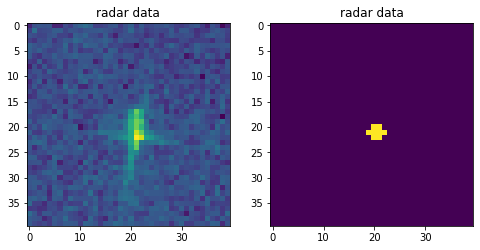

In [103]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2, figsize=(8, 8)) 

# use the created array to output your multiple images. 
axarr[0].imshow(VV_natural[1862-20:1862+20, 2998-20:2998+20])
axarr[0].set_title('radar data')
axarr[1].imshow(sar_classified[1862-20:1862+20, 2998-20:2998+20])  
axarr[1].set_title('radar data')